In [1]:
from tamkin import *
import numpy as np
import numpy
import re
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os

import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

from GPyOpt.methods import BayesianOptimization
import GPyOpt

import sys
#sys.path.insert(0, '../code/')
from tamkintools_multi_fidelity_bayesian.thermoAQ import AcquisitionThermo
from tamkintools_multi_fidelity_bayesian.tamkin_multi_fidelity import *

np.random.seed(20)

# Applying Thermo Acquisition to TS_scan2 with Multi-Fidelity




In [2]:
folder = "example_TS_scan2"

try:
    os.mkdir(folder,)
except:
    print("folder exists... stuff might be overwritten")
    
if folder[-1] != "/":
    folder += "/"

folder exists... stuff might be overwritten


In [3]:
e1_scan1 = load_rotscan_g03log("scan_data/RH/ScanRH.log")

TS_scan2  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan02s.log", top_indexes= [0] )

example = TS_scan2



energy_normer 23.839652087073773 KJ/mol
RT 2.4943416
beta_normer 9.557492881918728
energy range low: 23.839652087073773
energy range high: 11.334205598337576


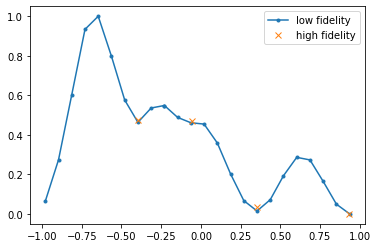

In [11]:
"""
high fidelity CC results:
"""
dihedral_high = np.array([  -71.11, -10.63 , 63.24, 168 ])/180
energy_high   = np.array([  -309.06084086, -309.06088137, -309.06485052, -309.06515783 ])*2625.5002
energy_high  -= np.min(energy_high)
energy_normer_high = np.max(energy_high)

"""
guess energy normer for high fidelity data...
based on intermediate datapoints we know (will be tested later)
"""

"""
reinitialize low fidelity energies to avoid mistakes
"""
dihedral = ( example.potential[0].copy() )/np.pi
energy   = example.potential[1].copy()
p = np.argsort( dihedral )
energy   = energy[p]
dihedral = dihedral[p]
energy   = energy*2625.5002
energy -= np.min(energy)

energy_normer = np.linalg.norm( energy, np.inf )
print("energy_normer",energy_normer,"KJ/mol")
beta = 1/(8.314472/1000*300)
print("RT", 1/beta)
beta_normer = energy_normer*beta
print("beta_normer", beta_normer)


"""
norm everything
"""
energy        = energy / energy_normer
energy_high   = energy_high / energy_normer#_high
#energy_high   = np.concatenate( ([1*energy_relation],energy_high) )
#energy_high_shift = 1 - energy_relation
#energy_high   += energy_high_shift
#dihedral_high = np.concatenate( ([7.9158128/180],dihedral_high) )

print("energy range low:",energy_normer)
print("energy range high:",energy_normer_high)

"""
now we shift energies to an interval between 0 and -1
... to not corrupt our MF model with the low fid high energy point in high fid data

--> solve this via pin function/option !

"""
plt.plot( dihedral , energy , ".-", label="low fidelity" )
plt.plot( dihedral_high , energy_high , "x", label="high fidelity" )
plt.legend()
plt.savefig(folder+"boltzmannAQ_energie_tests.png")

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1.]
angle range: 1.916667171436353
set angle range 2.0


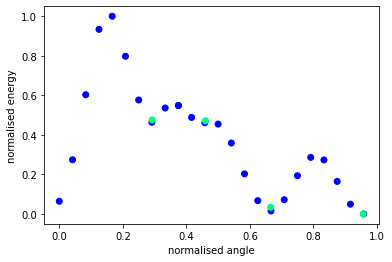

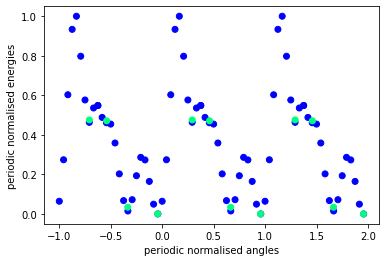

(87, 2)
(87, 1)
Optimization restart 1/5, f = -99.42582521074434
Warning - optimization restart 2/5 failed
Warning - optimization restart 3/5 failed
Warning - optimization restart 4/5 failed
Warning - optimization restart 5/5 failed


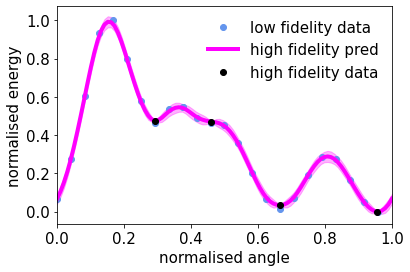

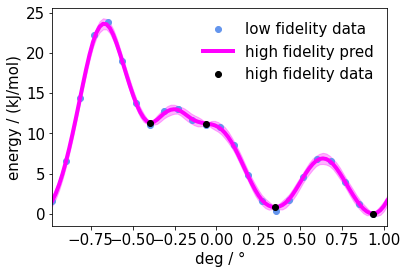

gp.,value,constraints,priors
multifidelity.Mat32.variance,0.22899019824669264,+ve,
multifidelity.Mat32.lengthscale,0.24404752936465748,+ve,
multifidelity.Mat32_1.variance,1.6991743454684775e-09,+ve,
multifidelity.Mat32_1.lengthscale,34.40636207766909,+ve,
multifidelity.scale,0.9970679294796254,,
mixed_noise.Gaussian_noise.variance,0.001,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [12]:

aa = np.concatenate( [dihedral, dihedral_high] )
bb = np.concatenate( [energy, energy_high] )*energy_normer
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral)), np.ones(len(dihedral_high)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=2.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results(folder+"multi_fidelity_norm_e1_scan1")
tmf.plot_results(folder+"multi_fidelity_TS_e1_scan1")

tmf.lin_mf_model.gpy_model

In [13]:
# x-range within bayesian opt takes place
xrange = (0,1)

    

# Based on: https://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/devel/manual/GPyOpt_constrained_optimization.ipynb
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': xrange}]

# Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = domain) 
#initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 4)

# CHOOSE the objective
# HERE: unknown and not used: insert dummy
stochastic_obj_func = lambda x : np.zeros(x.shape)
objective = GPyOpt.core.task.SingleObjective(stochastic_obj_func)
x_ini = np.atleast_2d([])
y_ini = np.atleast_2d([])

# CHOOSE the model type

# if theres any prior knowledge about the problem or data:
# add it here! (for example: noise)

# Matern32 kernel seems to be better suited for exploitation
#kernel = GPy.kern.Matern32(1)
#model = GPyOpt.models.GPModel(kernel=kernel,exact_feval=True,optimize_restarts=10,verbose=False)

# the more shaky default RBF kernel seems to be better suited for exploration
model = tmf #GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

# CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)
aquisition_optimizer.analytical_gradient_prediction = False

# CHOOSE the type of acquisition. Here: AcquisitionGibbs
acquisition = AcquisitionThermo(model, feasible_region, optimizer=aquisition_optimizer,
                                  jitter=1.0, beta=beta_normer, plot=True )

# CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Now create BO object
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, 
                                                evaluator, x_ini, y_ini,normalize_Y=False)


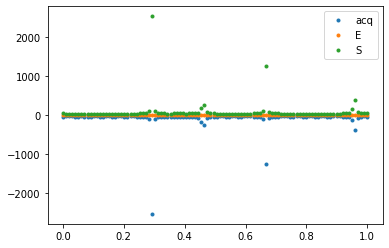

array([0.8989899])

In [14]:
sample_size = 100
x_sample = np.atleast_2d( np.linspace(0,1,sample_size) ).T

aqui = bo.acquisition._compute_acq(x_sample)

p = np.where( np.max(aqui) == aqui )
x_sample[p]

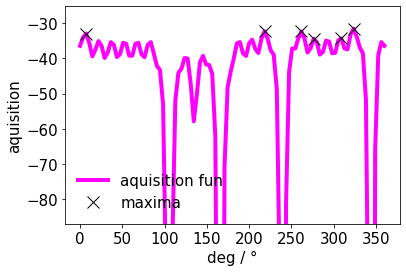

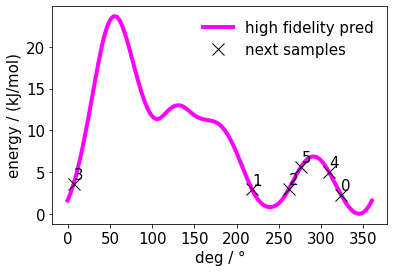

In [16]:
msize=12 
fsize=15
alpha=0.3
lsize = 4

xx  = np.squeeze(x_sample)*360
aqui = np.squeeze(aqui)

from scipy.signal import argrelmax,find_peaks
p,_ = find_peaks(aqui, prominence=.05) #threshold=0.005,distance=1)
#p  = np.squeeze( np.concatenate( (p1,p2), axis=1) )
p = np.squeeze(p)
f_all_maxima = aqui[p]
pp = p[ np.argsort(f_all_maxima)[::-1] ][:6]

plt.plot( xx, aqui, label="aquisition fun" ,color="magenta",linewidth=lsize )
plt.plot( xx[pp], aqui[pp], "xk", label="maxima",markersize=msize  )
plt.ylim( np.mean(aqui), np.max(aqui)*0.8  )
plt.ylabel("aquisition",fontsize=fsize)
plt.xlabel("deg / °",fontsize=fsize)
plt.xticks(fontsize=fsize)     
plt.yticks(fontsize=fsize)     
plt.legend(fontsize=fsize,frameon=False)
plt.savefig(folder+"MF_aquisition_e1_scan1.png", bbox_inches='tight')
plt.savefig(folder+"MF_aquisition_e1_scan1.pdf", bbox_inches='tight')
plt.show()
plt.close()


f, _ = bo.model.predict(x_sample)
f = np.squeeze(f)*energy_normer

plt.plot( xx, f, label="high fidelity pred" ,color="magenta",linewidth=lsize )
plt.plot( xx[pp], f[pp], "xk", label="next samples",markersize=msize  )

ns = np.arange( len(pp) )
texts = []
xx_new = xx[pp]
aq_new = aqui[pp]
yy_new = f[pp]
for i, n in enumerate(ns):
    texts.append(plt.text( xx_new[i], yy_new[i], str(int(n)), color="k",fontsize=fsize))
adjust_text(texts, x=xx_new, y=yy_new,
            only_move={'points':'xy', 'texts':'xy'},
            #arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
            autoalign='xy',force_static=0.15,force_explode=0.1)


plt.ylabel("energy / (kJ/mol)",fontsize=fsize)
plt.xlabel("deg / °",fontsize=fsize)
plt.xticks(fontsize=fsize)     
plt.yticks(fontsize=fsize)     
plt.legend(fontsize=fsize,frameon=False)#,loc='upper left')
plt.savefig(folder+"MF_f_aquisition_e1_scan1.png", bbox_inches='tight')
plt.savefig(folder+"MF_f_aquisition_e1_scan1.pdf", bbox_inches='tight')


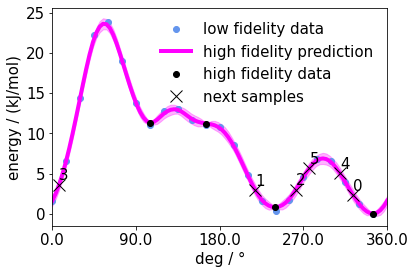

In [21]:
dummy = np.linspace(0,1,100)
hf_mean, hf_std = tmf.predict_hf_normed(dummy)
hf_mean = np.squeeze(hf_mean)*energy_normer
hf_std = np.squeeze(hf_std)*energy_normer

i = 0
w = tmf.unique_weights[i]
p = np.squeeze( np.where( tmf.fidelities==i ) )
plt.plot( tmf.normed_angles[p], tmf.normed_energies[p]*energy_normer,".", 
         color=tmf.colors[i], label=tmf.fidelity_labels[i],
        markersize=tmf.msize)  

plt.plot(dummy, hf_mean,color=tmf.colors[-1], label="high fidelity prediction",linewidth=tmf.lsize)
plt.fill_between(dummy, hf_mean-hf_std, hf_mean+hf_std,alpha=tmf.alpha,color=tmf.colors[-1])
#plt.scatter(self.angles, self.energies,c=self.fidelities, cmap=self.cmap)

i = 1
w = tmf.unique_weights[i]
p = np.squeeze( np.where( tmf.fidelities==i ) )
plt.plot( tmf.normed_angles[p], tmf.normed_energies[p]*energy_normer,".", 
         color=tmf.colors[i], label=tmf.fidelity_labels[i],
        markersize=tmf.msize)  

plt.plot( xx[pp]/360, f[pp], "xk", label="next samples",markersize=msize  )

ns = np.arange( len(pp) )
texts = []
xx_new = xx[pp]/360
aq_new = aqui[pp]
yy_new = f[pp]
for i, n in enumerate(ns):
    texts.append(plt.text( xx_new[i], yy_new[i], str(int(n)), color="k",fontsize=fsize))
adjust_text(texts, x=xx_new, y=yy_new,
            only_move={'points':'xy', 'texts':'xy'},
            #arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
            autoalign='xy',force_static=0.15,force_explode=0.1)

plt.xlim(0,1)

plt.ylabel("energy / (kJ/mol)",fontsize=tmf.fsize)
plt.xticks(fontsize=tmf.fsize)     
plt.yticks(fontsize=tmf.fsize)     

plt.xticks( np.linspace( 0,1,5 )  ,np.linspace( 0, 360, 5) ,fontsize=fsize)   
plt.xlabel("deg / °",fontsize=fsize)

plt.legend(fontsize=tmf.fsize,frameon=False)#,loc='center left', bbox_to_anchor=(1.01, 0.5))

save = folder +"all_in_one"

if save:
    plt.savefig(save+".png", bbox_inches='tight')
    plt.savefig(save+".pdf", bbox_inches='tight')
plt.show()
plt.close()   